# Homework part I

The first problem set contains basic tasks in pytorch.

__Note:__ Instead of doing this part of homework, you can prove your skills otherwise:
* A commit to pytorch or pytorch-based repos will do;
* Fully implemented seminar assignment in tensorflow or theano will do;
* Your own project in pytorch that is developed to a state in which a normal human can understand and appreciate what it does.

In [3]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
print(torch.__version__)

0.3.0.post4


### Task I - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gi f)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword. 


__1.1 the cannabola__ 
[_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

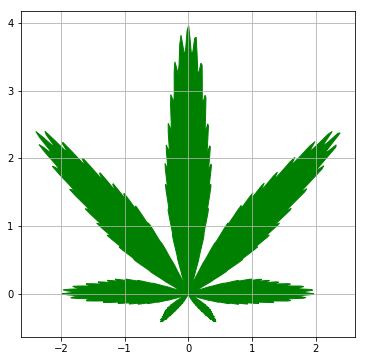

In [5]:
theta = torch.linspace(- np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(8*theta)) * (1 + 0.1*torch.cos(24*theta))*(0.9 + 0.05 * torch.cos(200*theta))*(1 + torch.sin(theta))
# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)


plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task II: the game of life

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/) in _pure pytorch_. 

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU! __ Indeed, what could be a better use of your gpu than simulating game of life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)
If you've skipped the url above out of sloth, here's the game of life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference numpy implementation that you must convert to pytorch.
_[numpy code inspired by: https://github.com/rougier/numpy-100]_


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format. 


In [120]:
from scipy.signal import convolve2d

def np_update(Z):
    # Count neighbours with convolution
    filters = np.array([[1,1,1],
                        [1,0,1],
                        [1,1,1]])
    
    N = convolve2d(Z,filters,mode='same')
    
    # Apply rules
    birth = (N==3) & (Z==0)
    survive = ((N==2) | (N==3)) & (Z==1)
    
    Z[:] = birth | survive
    return Z

In [121]:
def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.
    
    You can opt to create new tensor or change Z inplace.
    """
    
    filters_np = np.array([[1,1,1],
                        [1,0,1],
                        [1,1,1]])
    filters = Variable(torch.FloatTensor(filters_np).view([1,1,3,3]))
    N = torch.nn.functional.conv2d(Variable(Z[None, None, :, :]), filters, padding=1).data[0][0]
    
    birth = (N==3) & (Z==0)
    survive = ((N==2) | (N==3)) & (Z==1)
    
    Z[:] = birth | survive
    
    return Z

In [122]:
#initial frame
Z_numpy = np.random.choice([0,1],p=(0.5,0.5),size=(100,100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)

#your debug polygon :)
Z_new = torch_update(Z.clone())

#tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), "your pytorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

Well done!


<IPython.core.display.Javascript object>


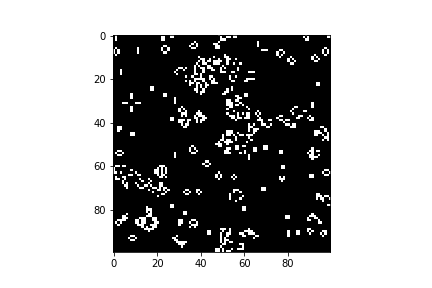

In [125]:
%matplotlib notebook
plt.ion()

#initialize game field
Z = np.random.choice([0,1],size=(100,100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    
    #update
    Z = torch_update(Z)
    
    #re-draw image
    ax.clear()
    ax.imshow(Z.numpy(),cmap='gray')
    fig.canvas.draw()


<IPython.core.display.Javascript object>


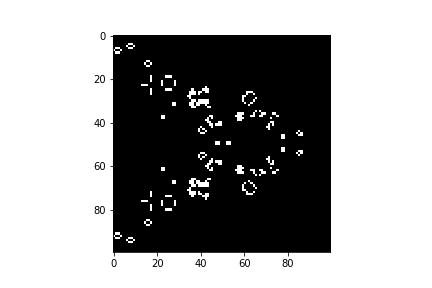

In [126]:
#Some fun setups for your amusement

#parallel stripes
Z = np.arange(100)%2 + np.zeros([100,100])
#with a small imperfection
Z[48:52,50]=1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z.numpy(),cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

```

```

```

```

```

```

```

```

```

```



### Task III: Going deeper
<img src="http://download.gamezone.com/uploads/image/data/1190338/article_post_width_a88.jpg" width=360>
Your third trial is to build your first neural network [almost] from scratch and pure torch.

This time you will solve yet another digit recognition problem, but at a greater scale
* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression. You can implement it with either 


With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train for __categorical crossentropy__  (see [here](https://www.kaggle.com/wiki/LogLoss)).  Write your own loss or use `torch.nn.functional.nll_loss`. Just make sure you understand what it accepts as an input.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.


__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors. 
If you feel confident enogh, just start coding right away and get there ~~if~~ once you need to untangle yourself. 



In [4]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


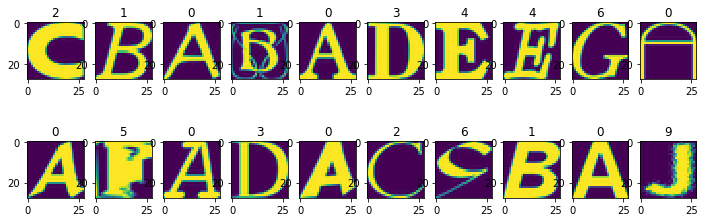

In [5]:
%matplotlib inline
plt.figure(figsize=[12,4])
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(X_train[i].reshape([28,28]))
    plt.title(str(y_train[i]))

In [6]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(784, 256))
model.add_module('relu', nn.ReLU())
model.add_module('l2', nn.Linear(256, 10))
model.add_module('softmax', nn.Softmax(dim=1))

In [7]:
opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.3)

In [15]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(784, 256))
model.add_module('relu', nn.ReLU())
model.add_module('l2', nn.Linear(256, 10))
model.add_module('softmax', nn.Softmax(dim=1))

opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.3)

In [16]:
history = []

for i in range(120000):
    ix = np.random.randint(0, len(X_train), 256)
    x_batch = Variable(torch.FloatTensor(X_train[ix]))
    y_batch = Variable(torch.LongTensor(y_train[ix]))

    # predict probabilities
    y_predicted = model.forward(x_batch)
    
    loss = torch.nn.functional.nll_loss(input=y_predicted, target=y_batch)
    
    # compute gradients
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy()[0])
    
    if i % 10000 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))


max_val, max_ind = torch.max(model.forward(Variable(torch.FloatTensor(X_train))),1)
print('Train accuracy: {:.4f}'.format(np.mean(max_ind.data.numpy() == y_train)))

max_val, max_ind = torch.max(model.forward(Variable(torch.FloatTensor(X_test))),1)
print('Test accuracy: {:.4f}'.format(np.mean(max_ind.data.numpy() == y_test)))

step #0 | mean loss = -0.091
step #10000 | mean loss = -0.812
step #20000 | mean loss = -0.857
step #30000 | mean loss = -0.867
step #40000 | mean loss = -0.882
step #50000 | mean loss = -0.893
step #60000 | mean loss = -0.890
step #70000 | mean loss = -0.897
step #80000 | mean loss = -0.903
step #90000 | mean loss = -0.894
step #100000 | mean loss = -0.913
step #110000 | mean loss = -0.910
Train accuracy: 0.9236
Test accuracy: 0.9034


90% achieved!

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


# SPOILERS!

Recommended pipeline

* Adapt logistic regression from week2 seminar assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - softmax (exp over sum of exps) can implemented manually or as nn.Softmax (layer) F.softmax (function)
  - probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - you can also try momentum/rmsprop/adawhatever
    - in which case sample should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just output layer :)
  - __Do not initialize weights with zeros__ (due to symmetry effects). A gaussian noize with small variance will do.
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve. 
  - In ideal casae this totals to 2 .dot's, 1 softmax and 1 sigmoid
  - __make sure this neural network works better than logistic regression__
  
* Now's the time to try improving the network. Consider layers (size, neuron count),  nonlinearities, optimization methods, initialization - whatever you want, but please avoid convolutions for now.
  
* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate log P(y|x) as via F.log_softmax(layer_before_softmax)

